# Deuterium retention in tungsten

```{tags} 1D, TDS, trapping, transient
```

This validation case is a thermo-desorption spectrum measurement perfomed by Hodille et al. TODO: INSERT CITATION

Deuterium ions at ??? eV were implanted in a 0.8 mm thick sample of high purity tungsten foil (PW).

The ion beam with an incident flux of $5.4 \times 10^{18} \ \mathrm{D \ m^{-2} \ s^{-1}}$ was turned on for ??? s.

To reproduce this experiment, three traps are needed: 2 intrinsic traps and 2 extrinsic traps.
The extrinsic trap represents the defects created during the ion implantation.

## FESTIM code

In [30]:
import festim as F
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

model = F.Simulation()

vertices = np.concatenate(
    [
        np.linspace(0, 3e-9, num=200),
        np.linspace(3e-9, 1e-8, num=300),
        np.linspace(1e-8, 1e-7, num=100),
    ]
)

model.mesh = F.MeshFromVertices(vertices)
# Material Setup, only W
tungsten = F.Material(
    id=1,
    D_0=4.1e-07,  # m2/s
    E_D=0.39,  # eV
)

model.materials = tungsten
import sympy as sp

storage_temp = 300 # K
exposure2_temp = 600 # K
temperature_ramp = 15 / 60 # K/s
hold_temp = 1323 # K
stop_exposure1 = 4 * 3600 # s

def setup(exposure1_temp, density_1, density_2):
    """
    Change parameters based on the exposure temperature 
    and trap densities for each experiment.
    """

    # ### Temperature Settings ### #
    stop_storage1 = stop_exposure1 + (exposure1_temp - storage_temp) / temperature_ramp # s

    stop_exposure2 = stop_storage1 + 19 * 3600
    stop_storage2 = stop_exposure2 + (exposure2_temp - storage_temp) / temperature_ramp

    stop_tds = stop_storage2 + (hold_temp - storage_temp) / temperature_ramp

    model.T = F.Temperature(value=sp.Piecewise(
        (exposure1_temp, F.t < stop_exposure1),
        (exposure1_temp - temperature_ramp * (F.t - stop_exposure1), F.t < stop_storage1),
        (exposure2_temp, F.t < stop_exposure2),
        (exposure2_temp - temperature_ramp * (F.t - stop_exposure2), F.t < stop_storage2),
        (storage_temp + temperature_ramp * (F.t - stop_storage2), F.t < stop_tds),
        (hold_temp, True),
    ))

    # ### Source Settings ### #

    three_min = 3 * 60 # s
    incident_flux = 5.4e18  # D m^2 s^-1, beam strength from paper
    ion_flux = sp.Piecewise(
        (incident_flux, F.t < stop_exposure1 + three_min),
        (0, F.t < stop_storage1),
        (incident_flux, F.t < stop_exposure2 + three_min),
        (0, True)
    )

    source_term = F.ImplantationFlux(
        flux=ion_flux, imp_depth=0.65e-9, width=0.9e-9, volume=1  # H/m2/s  # m  # m
    )

    model.sources = [source_term]

    # ### Trap Settings ### #

    w_atom_density = 6.3e28  # atom/m3

    # Undamaged material traps
    trap_1 = F.Trap(
        k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=0.85,
        density= 0.01 * w_atom_density,
        materials=tungsten,
    )

    trap_2 = F.Trap(
        k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.0,
        density= 0.01 * w_atom_density,
        materials=tungsten,
    )

    # Damage traps

    damage_distribution = sp.Piecewise(
        (1 - 1/(1 + sp.exp(-12.04*(F.x - 1.2))), F.x > 0),
        (0 , True)
    )

    trap_3 = F.Trap(
        k_0 = 4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
        E_k = 0.39,
        p_0 = 1e13,
        E_p = 1.83,
        density = damage_distribution * density_1 * w_atom_density,
        materials = tungsten,
    )

    trap_4 = F.Trap(
        k_0 = 4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
        E_k = 0.39,
        p_0 = 1e13,
        E_p = 2.10,
        density = damage_distribution * density_2 * w_atom_density,
        materials = tungsten
    )

    model.traps = [trap_1, trap_2, trap_3, trap_4]


    # ### Boundary Conditions ### 
    model.boundary_conditions = [F.DirichletBC(surfaces=[1, 2], value=0, field=0)]

    model.dt = F.Stepsize(
        initial_value=1,
        stepsize_change_ratio=1.1,
        max_stepsize=lambda t: 50 if t > stop_storage2 else None, #TODO: change this, its crude
        dt_min=1e-05,
        milestones=[stop_exposure1, stop_storage1, stop_exposure2, stop_storage2, stop_tds]
    )

    model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-010,
        final_time = stop_tds #+ 0.5 * 3600 # time to reach max temp
    )

    derived_quantities = F.DerivedQuantities(
        [
            F.TotalVolume("solute", volume=1),
            F.TotalVolume("retention", volume=1),
            F.TotalVolume("1", volume=1),
            F.TotalVolume("2", volume=1),
            F.TotalVolume("3", volume=1),
            F.TotalVolume("4", volume=1),
            F.HydrogenFlux(surface=1),
            F.HydrogenFlux(surface=2),
        ],
    )

    txt_export = F.TXTExport(
        field="solute",
        filename=f"./{exposure1_temp}K.txt",
        times=[model.settings.final_time],
    )

    model.exports = [derived_quantities, txt_export]

    return derived_quantities, stop_storage2

## Comparison with experimental data

The results produced by FESTIM are in good agreement with the experimental data. The grey areas represent the contribution of each trap to the global TDS spectrum.

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/komodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        8.9e+04 s    Ellapsed time so far: 17.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/komodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        8.9e+04 s    Ellapsed time so far: 13.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/komodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


ValueError: stepsize reached minimal value

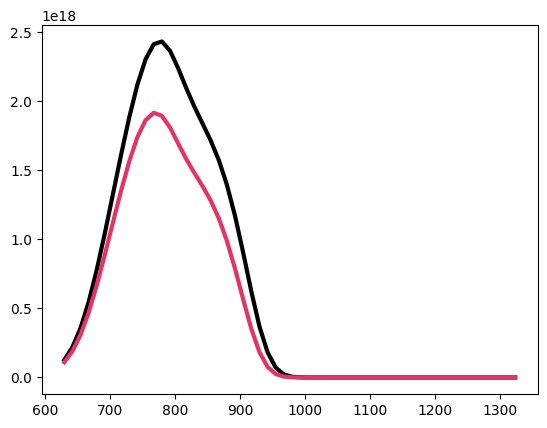

In [31]:
exposure_temps = [450, 600, 800, 900, 1000] #K
damage_density_1 = [0.205, 0.160, 0.100, 0.095, 0.100]
damage_density_2 = [0.110, 0.085, 0.080, 0.065, 0.060]

colors = [(0.9*(i % 2), 0.2*(i % 4), 0.4*(i % 3)) for i in range(5)]

pack = zip(range(0, len(exposure_temps)),exposure_temps, damage_density_1, damage_density_2)
for i, exposure_temp, d1, d2 in pack:
    derived_quantities, stop_storage2 = setup(exposure_temp, d1, d2)

    model.initialise()
    model.run()

    t = derived_quantities.t
    flux_left = derived_quantities.filter(fields="solute", surfaces=1).data
    flux_right = derived_quantities.filter(fields="solute", surfaces=2).data
    flux_total = -np.array(flux_left) - np.array(flux_right)

    t = np.array(t)

    rem = sum((time <= stop_storage2) for time in t)

    t = t[rem:]
    temp = [storage_temp + (time - stop_storage2)*temperature_ramp for time in t]
    flux_total = flux_total[rem:]

    # plotting simulation data
    plt.plot(temp, flux_total, linewidth=3, label=f"{exposure_temp} K", color = colors[i])

    # plotting original data
    """ experimental_tds = np.genfromtxt(f"original_{exposure_temp}.csv", delimiter=",")
    experimental_temp = experimental_tds[:, 0]
    experimental_flux = experimental_tds[:, 1]
    plt.scatter(experimental_temp, experimental_flux, color="green", label=f"{exposure_temp}K", s=16) """

plt.legend()
plt.xlim(500, 1200)
plt.ylim(bottom=0)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Temperature (K)")

plt.show()

FileNotFoundError: ./800K.txt not found.

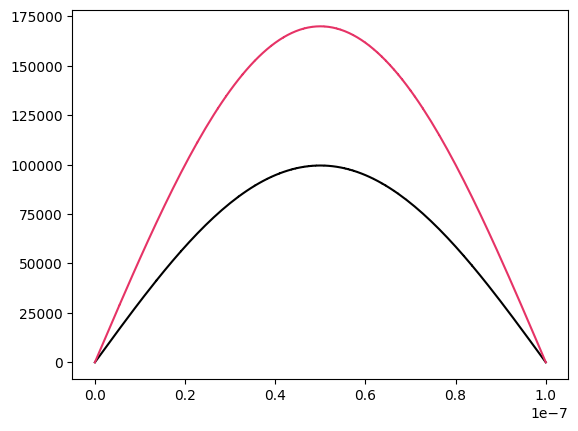

In [34]:

for i, exposure_temp in enumerate(exposure_temps):
    # plotting depth distribution
    data = np.genfromtxt(f"./{exposure_temp}K.txt", skip_header=1, delimiter=",")
    data = data[data[:, 0].argsort()]  # make sure data is sorted

    plt.plot(data[:, 0], data[:, 1], label=f"{exposure_temp}K", color=colors[i])

```{note}
The experimental data was taken from Figure 5 of the original experiment paper {cite}`ogorodnikova_deuterium_2003` using [WebPlotDigitizer](https://automeris.io/)
```